In [1]:
%matplotlib inline

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd

In [90]:
from datetime import timedelta 

In [84]:
from sklearn.model_selection import StratifiedShuffleSplit

Если сказать кратко по данным, то делаю так (успею или нет еще не знаю):
* всю историю решил агрегировать - сделать BoW с подсчетом 
    * NUM_SOURCE
    * CREDIT_ACTIVE
    * CREDIT_COLLATERAL
    * CNT_CREDIT_PROLONG
    * CREDIT_TYPE
    * CREDIT_DELAY30
    * CREDIT_DELAY5 
    * CREDIT_DELAY60
    * CREDIT_DELAY90
    * CREDIT_CURRENCY

* просто просуммировать:
    * AMT_CREDIT_SUM
    * AMT_CREDIT_SUM_DEBT 
    * AMT_CREDIT_SUM_LIMIT
    * AMT_CREDIT_SUM_OVERDUE
    * AMT_REQ_SOURCE_HOUR
    * AMT_REQ_SOURCE_DAY 
    * AMT_REQ_SOURCE_WEEK
    * AMT_REQ_SOURCE_MON 
    * AMT_REQ_SOURCE_QRT 
    * AMT_REQ_SOURCE_YEAR
    * AMT_CREDIT_MAX_OVERDUE
    * CREDIT_DAY_OVERDUE

* абсолютные даты удаляю
    * SK_DATE_DECISION             datetime64[ns]
    * DTIME_CREDIT                 datetime64[ns]
    * DTIME_CREDIT_ENDDATE         datetime64[ns]
    * DTIME_CREDIT_ENDDATE_FACT    datetime64[ns]

* TEXT_PAYMENT_DISCIPLINE процессится по-другому - предварительно удалить 'C' - закрытый договор, подсчет числа своевременных платежей, числа просроченных платежей, докинуть отношения и разность просроченных и своевременных платежей

* CREDIT_FACILITY содержит неизвеструю семантику и очень много пропусков, пока удалю. потом если будет время, попробую восстанавливать с помощью других полей.

* оставшиеся пока удалю, до тех пор, пока не придумаю что с ними делать.
    * DTIME_CREDIT_UPDATE
    * CREDIT_DELAY_MORE
    * AMT_ANNUITY

Вспомогательные функции:

In [109]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def encode_with_LabelEncoder(df, column_name, suffix='_le'):
    label_encoder = LabelEncoder()
    label_encoder.fit(df[column_name])
    df[column_name+suffix] = label_encoder.transform(df[column_name])
    df.drop([column_name], axis=1, inplace=True)
    return label_encoder

def encode_with_existing_LabelEncoder(df, column_name, label_encoder):
    df[column_name+'_le'] = label_encoder.transform(df[column_name])
    df.drop([column_name], axis=1, inplace=True)

def encode_with_OneHotEncoder_and_delete_column(df, column_name):
    le_encoder = encode_with_LabelEncoder(df, column_name)
    return perform_dummy_coding_and_delete_column(df, column_name, le_encoder), le_encoder

def encode_with_OneHotEncoder_using_existing_LabelEncoder_and_delete_column(df, column_name, le_encoder):
    encode_with_existing_LabelEncoder(df, column_name, le_encoder)
    return perform_dummy_coding_and_delete_column(df, column_name, le_encoder)

def perform_dummy_coding_and_delete_column(df, column_name, le_encoder):
    oh_encoder = OneHotEncoder(sparse=False)
    oh_features = oh_encoder.fit_transform(df[column_name+'_le'].values.reshape(-1,1))
    ohe_columns=[column_name + '=' + le_encoder.classes_[i] for i in range(oh_features.shape[1])]

    df.drop([column_name+'_le'], axis=1, inplace=True)

    df_with_features = pd.DataFrame(oh_features, columns=ohe_columns)
    df_with_features.index = df.index
    return pd.concat([df, df_with_features], axis=1)

In [ ]:
def split_data_and_target(data, target_name, inplace=True):
    y = data[target_name]
    X = None
    
    if inplace:
        data.drop([target_name], inplace=inplace, axis=1)
        X = data
    else:
        X = data.drop([target_name], inplace=inplace, axis=1)
    return X, y

In [ ]:
def merge_sources(data):
    result = pd.DataFrame([])
    row_len = data.shape[1]
    
    for unique_id in data['ID'].unique():
        for source in range(1,5):
            row = pd.DataFrame([])
            if ((data['ID'] == unique_id) & (data['NUM_SOURCE'] == source)).any():
                row = row.append(data[((data['ID'] == unique_id) & (data['NUM_SOURCE'] == source))].add_prefix(str(source) + '_'))
            else:
                row = row.append(pd.DataFrame([[np.nan] * row_len], columns=data.columns).add_prefix(str(source) + '_'))
            result = result.append(row)
    return result

In [ ]:
def extract_textpayment_features(data):

In [43]:
def transofrm_to_date(data, columns):   
    for column in columns:
        if column == 'SK_DATE_DECISION':
            data['SK_DATE_DECISION'].apply(str)
            data[column] = pd.to_datetime(data[column], format='%Y%m%d')
        else:
            data[column] = pd.to_datetime(data[column], format='%d.%m.%Y')

In [ ]:
def fill_dates(data):
    '''
    
    '''
    
    data['DTIME_CREDIT_ENDDATE']

In [ ]:
def merge_histories(data):
    return

In [3]:
train = pd.read_csv('./hc_final/train.csv')

In [20]:
train = train.rename(columns={train.columns[0]: 'ID'})

In [21]:
train.head()

,ID,SK_DATE_DECISION,DEF,NUM_SOURCE,CREDIT_ACTIVE,CREDIT_COLLATERAL,CREDIT_CURRENCY,DTIME_CREDIT,CREDIT_DAY_OVERDUE,DTIME_CREDIT_ENDDATE,...,CREDIT_DELAY90,CREDIT_DELAY_MORE,AMT_REQ_SOURCE_HOUR,AMT_REQ_SOURCE_DAY,AMT_REQ_SOURCE_WEEK,AMT_REQ_SOURCE_MON,AMT_REQ_SOURCE_QRT,AMT_REQ_SOURCE_YEAR,AMT_ANNUITY,TEXT_PAYMENT_DISCIPLINE
0,24368,20150901,0,1,0,0,rur,27.03.2011,0,27.01.2012,...,0,0,0,0,0,0,0,3,0.0,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC0...
1,24368,20150901,0,3,0,0,rur,03.11.2011,0,30.11.2014,...,0,0,0,0,0,0,0,3,0.0,CCCCCCCCCCCCCC0X000000000000000000000XXXXXXXXXX
2,24368,20150901,0,4,0,0,rur,03.11.2011,0,30.11.2014,...,0,0,0,0,0,0,0,3,NaN,CCCCCCCCCCCCCC000000000000000000000000XXXXXXXXX
3,24368,20150901,0,3,0,0,rur,24.02.2012,0,21.02.2014,...,0,0,0,0,0,0,0,3,NaN,CCCCCCCCCCCCCCCCCCCCX0X0XX00000X00X0XX0X00XX
4,24368,20150901,0,4,0,0,rur,24.02.2012,0,21.02.2014,...,0,0,0,0,0,0,0,3,NaN,CCCCCCCCCCCCCCCCCCCC000000000000000000000000


In [93]:
train.dtypes

ID                                    int64
SK_DATE_DECISION             datetime64[ns]
NUM_SOURCE                            int64
CREDIT_ACTIVE                         int64
CREDIT_COLLATERAL                     int64
CREDIT_CURRENCY                      object
DTIME_CREDIT                 datetime64[ns]
CREDIT_DAY_OVERDUE                    int64
DTIME_CREDIT_ENDDATE         datetime64[ns]
DTIME_CREDIT_ENDDATE_FACT    datetime64[ns]
CREDIT_FACILITY                     float64
AMT_CREDIT_MAX_OVERDUE              float64
CNT_CREDIT_PROLONG                    int64
AMT_CREDIT_SUM                      float64
AMT_CREDIT_SUM_DEBT                 float64
AMT_CREDIT_SUM_LIMIT                float64
AMT_CREDIT_SUM_OVERDUE              float64
CREDIT_SUM_TYPE                       int64
CREDIT_TYPE                           int64
DTIME_CREDIT_UPDATE                  object
CREDIT_DELAY30                        int64
CREDIT_DELAY5                         int64
CREDIT_DELAY60                  

* Переменные, характеризующие рассматриваемую заявку на кредит:
    * ID - идентификатор заявки на кредит
    * SK_DATE_DECISION - дата рассмотрения заявки
    * DEF – целевая переменная
        * 1 – кредит не был возвращен
        * 0 – кредит был возвращен


* Переменные – атрибуты кредита из кредитной истории:
    * NUM_SOURCE - номер источника данных
    * CREDIT_ACTIVE - статус кредитного договора
        * 0 - договор закрыт
        * 1 - договор активен
        * 2 - договор продан
        * 3 - безнадежный долг
        * 4 - договор реструктурирован/ рефинансирован
        * 5 - договор передан коллекторам
        * 6 - договор заблокирован
        * 7 - договор отменен
        * 8 – прекращение информирования по договору
        * 9 – заемщик освобожден от дальнейшего исполнения требований кредиторов по причине банкротства
    * CREDIT_COLLATERAL - признак погашения за счет обеспечения / поручительства
        * 1 - было такое погашение
        * 0- нет
    * CREDIT_CURRENCY валюта кредита
        * 810 или RUR - рубль
        * 840 или USD - американский доллар
        * 978 или EUR - евро
        * 756 или CHF - швейцарский франк
        * 392 или JPY - японская йена
    * DTIME_CREDIT - дата выдачи кредита
    * CREDIT_DAY_OVERDUE - текущая просроченная задолженность, дни
    * DTIME_CREDIT_ENDDATE -планируемая дата окончания кредита
    * DTIME_CREDIT_ENDDATE_FACT - фактическая дата окончания кредита
    * CREDIT_FACILITY – семантика поля неизвестна
    * AMT_CREDIT_MAX_OVERDUE - максимальная просроченная задолженность за все время жизни договора, сумма
    * CNT_CREDIT_PROLONG - число пролонгаций кредита
    * AMT_CREDIT_SUM - сумма кредита
    * AMT_CREDIT_SUM_DEBT - сумма оставшегося долга
    * AMT_CREDIT_SUM_LIMIT – лимит (для карт)
    * AMT_CREDIT_SUM_OVERDUE - текущая просроченная задолженность, сумма
    * CREDIT_SUM_TYPE - тип задолженностей
        * 0 - все задолженности по ОД
        * 1 - полные суммы с %
    * CREDIT_TYPE - тип договора
        * 0 - неизвестный тип кредита
        * 1 - кредит на автомобиль
        * 2 - лизинг
        * 3 - ипотека
        * 4 - кредитная карта
        * 5 - потребительский кредит
        * 6 - кредит на развитие бизнеса
        * 7 - кредит на пополнение оборотных средств
        * 8 - кредит на покупку оборудования
        * 9 - кредит на строительство недвижимости
        * 10 - кредит на покупку акций (маржинальное кредитование)
        * 11 - межбанковский кредит
        * 12 - кредит мобильного оператора
        * 13 - кредит на обучение
        * 14 - дебетовая карта с овердрафтом
        * 15 - ипотека (первичный рынок)
        * 16 - ипотека (вторичный рынок)
        * 17 - ипотека (ломбардный кредит)
        * 18 - кредит наличными (нецелевой)
        * 19 - микрозайм
        * 90 - договор поручительства
        * 99 - другой тип кредита
    * DTIME_CREDIT_UPDATE - дата последнего обновления информации в источнике
    * CREDIT_DELAY30 - число просроченных на 6..30 дней платежей
    * CREDIT_DELAY5 - число просроченных на не более 5 дней платежей
    * CREDIT_DELAY60 - число просроченных на 31..60 дней платежей
    * CREDIT_DELAY90 - число просроченных на 61..90 дней платежей
    * CREDIT_DELAY_MORE - число просроченных на 90+ дней платежей
    * AMT_REQ_SOURCE_HOUR - число запросов к источнику за последний час
    * AMT_REQ_SOURCE_DAY - число запросов к источнику за последний день (не считая последний час)
    * AMT_REQ_SOURCE_WEEK - число запросов к источнику за последнюю неделю (не считая последний день)
    * AMT_REQ_SOURCE_MON - число запросов к источнику за последний месяц (не считая последнюю неделю)
    * AMT_REQ_SOURCE_QRT - число запросов к источнику за последний квартал (не считая последний месяц)
    * AMT_REQ_SOURCE_YEAR - число запросов к источнику за последний год (не считая последний квартал)
    * AMT_ANNUITY - сумма ежемесячного платежа
    * TEXT_PAYMENT_DISCIPLINE - платежная строка, вектор статусов платежей по кредиту, возможные статусы:
        * 0 – своевременный платеж
        * 1 – просрочка 1..30 дней
        * 2 – просрочка 31..60 дней
        * 3 – просрочка 61..90 дней
        * 4 – просрочка 91..120 дней
        * 5 – просрочка 121+ дней, передан коллекторам, продан, списан
        * X – статус неизвестен
        * C – договор закрыт

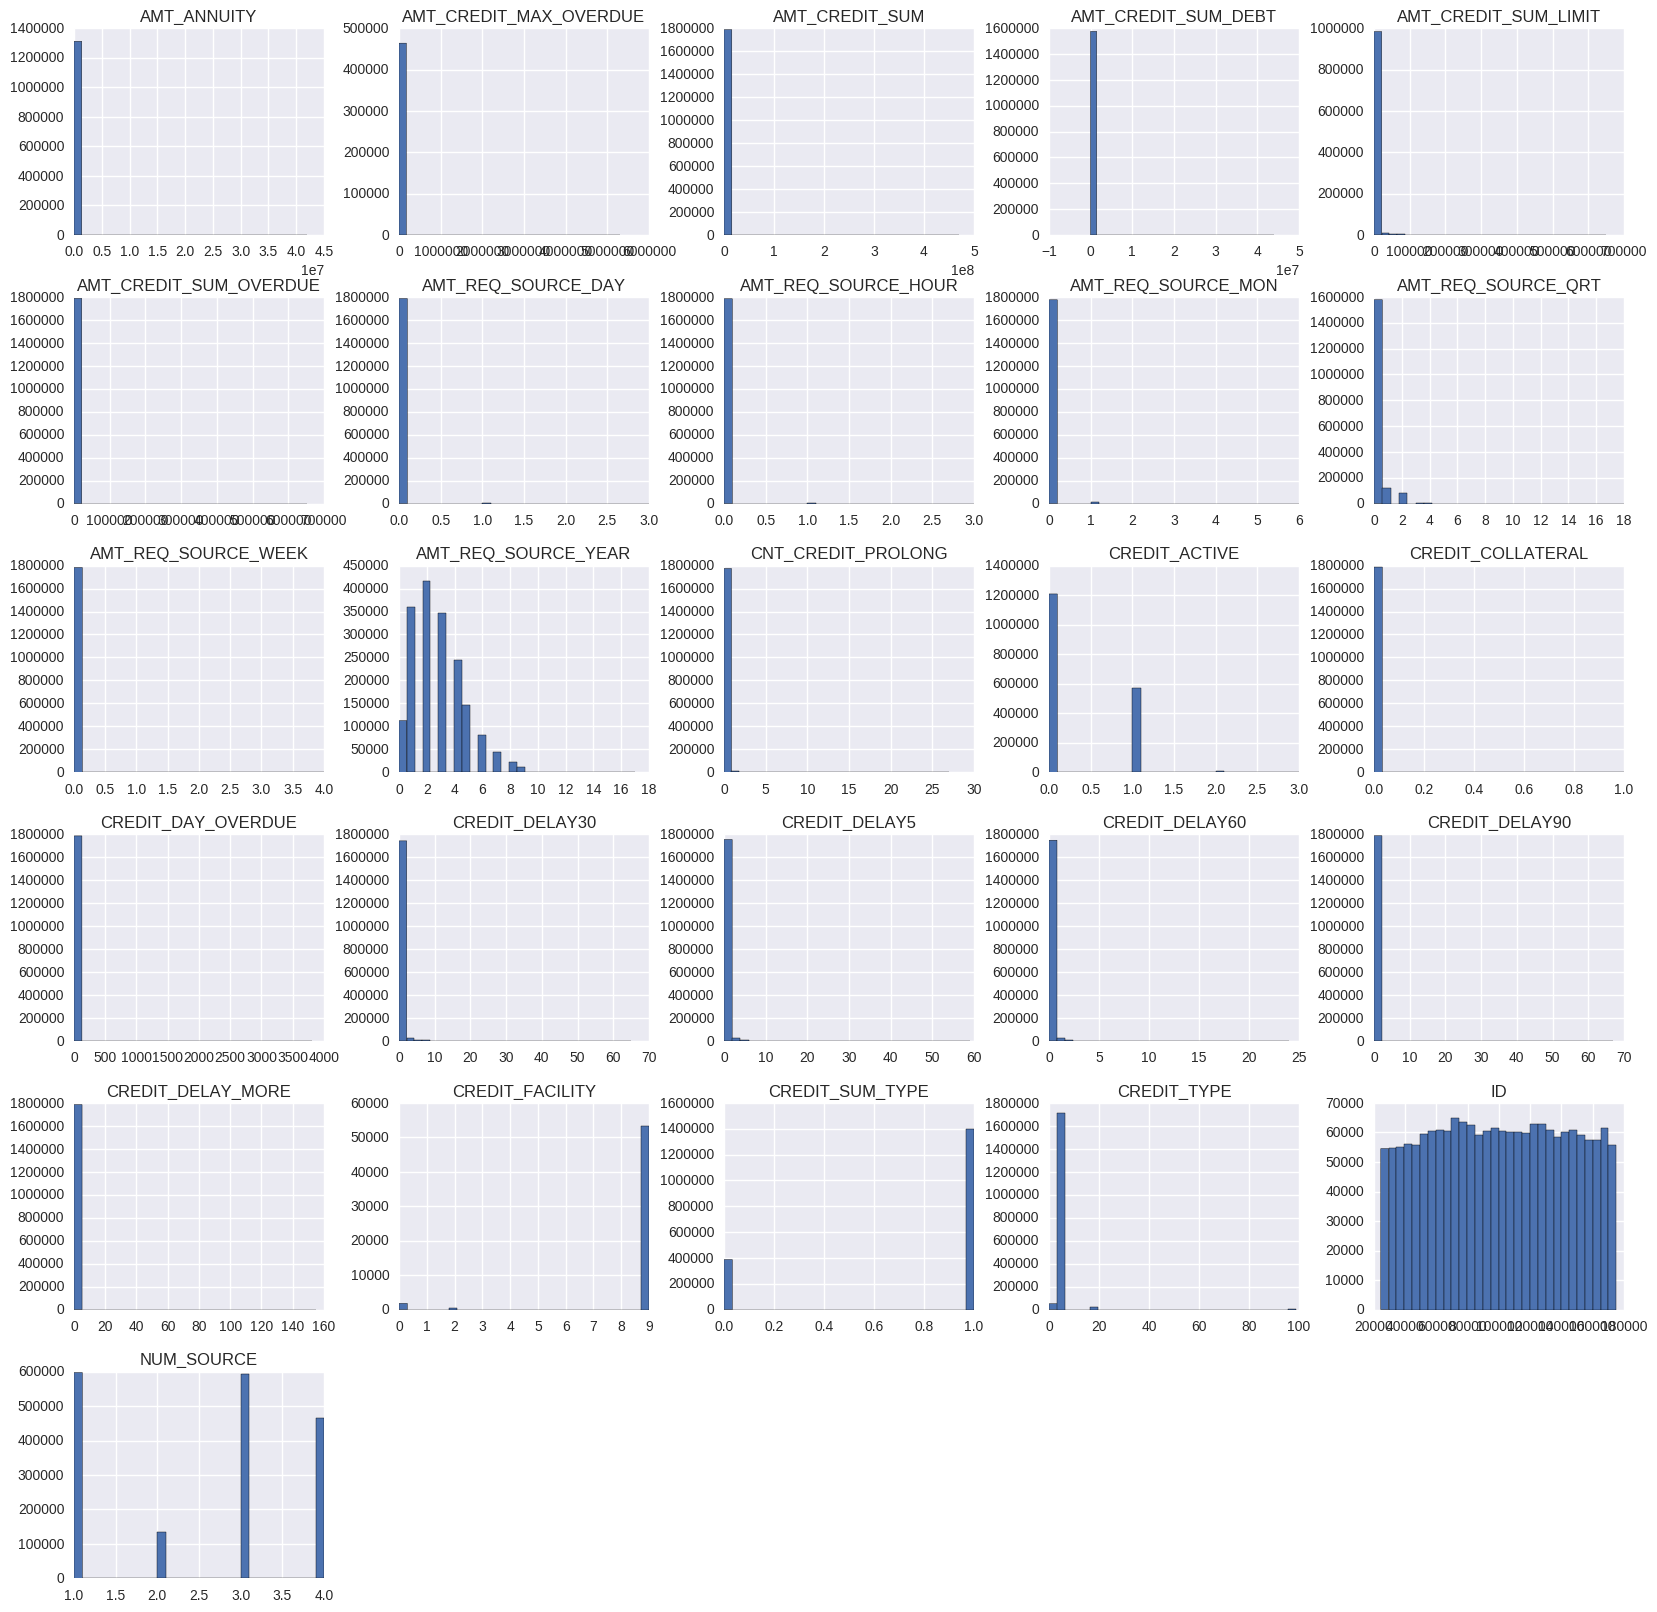

In [94]:
_ = train.hist(train.columns, bins=30, figsize=(20, 20))

Проверим, что одному ID соответствует только по одному уникальному значению DEF:

In [24]:
train[['ID', 'DEF']].groupby('ID')['DEF'].nunique().unique()

array([1])

In [28]:
y = train[['ID', 'DEF']].drop_duplicates().set_index('ID')

In [29]:
train.drop(['DEF'], inplace=True, axis=1)

In [30]:
print train.shape, y.shape

(1787571, 33) (135155, 1)


In [31]:
y['DEF'].value_counts()

0    130624
1      4531
Name: DEF, dtype: int64

Классы довольно несбалансированы.

In [54]:
train['CREDIT_FACILITY'].unique()

array([ nan,   9.,   0.,   2.,   1.])

In [69]:
from collections import Counter
Counter(train['CREDIT_FACILITY'].dropna())

Counter({0.0: 1802, 1.0: 30, 2.0: 516, 9.0: 53277})

In [63]:
train.shape[0]

1787571

In [39]:
tmp = train.isnull().sum()
tmp[tmp >= 1]

DTIME_CREDIT_ENDDATE           91370
DTIME_CREDIT_ENDDATE_FACT     571487
CREDIT_FACILITY              1731946
AMT_CREDIT_MAX_OVERDUE       1323482
AMT_CREDIT_SUM                    29
AMT_CREDIT_SUM_DEBT           208766
AMT_CREDIT_SUM_LIMIT          782106
AMT_ANNUITY                   475829
TEXT_PAYMENT_DISCIPLINE         1947
dtype: int64

In [ ]:
train.

Поля, имеющие пропуски:
* DTIME_CREDIT_ENDDATE -планируемая дата окончания кредита
* DTIME_CREDIT_ENDDATE_FACT - фактическая дата окончания кредита
* CREDIT_FACILITY – семантика поля неизвестна
* AMT_CREDIT_MAX_OVERDUE - максимальная просроченная задолженность за все время жизни договора, сумма
* AMT_CREDIT_SUM_DEBT - сумма оставшегося долга
* AMT_CREDIT_SUM_LIMIT – лимит (для карт)
* AMT_ANNUITY - сумма ежемесячного платежа
* TEXT_PAYMENT_DISCIPLINE - платежная строка, вектор статусов платежей по кредиту, возможные статусы:
    * 0 – своевременный платеж
    * 1 – просрочка 1..30 дней
    *    2 – просрочка 31..60 дней
    *    3 – просрочка 61..90 дней
    *    4 – просрочка 91..120 дней
    *    5 – просрочка 121+ дней, передан коллекторам, продан, списан
    *    X – статус неизвестен
    *    C – договор закрыт

Пропуски в данных в основном следуют из-за пропусков в датах

In [44]:
transofrm_to_date(train, ['SK_DATE_DECISION', 'DTIME_CREDIT', 'DTIME_CREDIT_ENDDATE', 'DTIME_CREDIT_ENDDATE_FACT'])

In [45]:
train.head()

,ID,SK_DATE_DECISION,NUM_SOURCE,CREDIT_ACTIVE,CREDIT_COLLATERAL,CREDIT_CURRENCY,DTIME_CREDIT,CREDIT_DAY_OVERDUE,DTIME_CREDIT_ENDDATE,DTIME_CREDIT_ENDDATE_FACT,...,CREDIT_DELAY90,CREDIT_DELAY_MORE,AMT_REQ_SOURCE_HOUR,AMT_REQ_SOURCE_DAY,AMT_REQ_SOURCE_WEEK,AMT_REQ_SOURCE_MON,AMT_REQ_SOURCE_QRT,AMT_REQ_SOURCE_YEAR,AMT_ANNUITY,TEXT_PAYMENT_DISCIPLINE
0,24368,2015-09-01,1,0,0,rur,2011-03-27,0,2012-01-27,2012-01-25,...,0,0,0,0,0,0,0,3,0.0,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC0...
1,24368,2015-09-01,3,0,0,rur,2011-11-03,0,2014-11-30,2014-08-04,...,0,0,0,0,0,0,0,3,0.0,CCCCCCCCCCCCCC0X000000000000000000000XXXXXXXXXX
2,24368,2015-09-01,4,0,0,rur,2011-11-03,0,2014-11-30,2014-08-04,...,0,0,0,0,0,0,0,3,NaN,CCCCCCCCCCCCCC000000000000000000000000XXXXXXXXX
3,24368,2015-09-01,3,0,0,rur,2012-02-24,0,2014-02-21,2014-02-21,...,0,0,0,0,0,0,0,3,NaN,CCCCCCCCCCCCCCCCCCCCX0X0XX00000X00X0XX0X00XX
4,24368,2015-09-01,4,0,0,rur,2012-02-24,0,2014-02-21,2014-02-21,...,0,0,0,0,0,0,0,3,NaN,CCCCCCCCCCCCCCCCCCCC000000000000000000000000


In [79]:
train[['SK_DATE_DECISION', 'DTIME_CREDIT_ENDDATE', 'DTIME_CREDIT_ENDDATE_FACT', 'CREDIT_DAY_OVERDUE']]

,SK_DATE_DECISION,DTIME_CREDIT_ENDDATE,DTIME_CREDIT_ENDDATE_FACT,CREDIT_DAY_OVERDUE
0,2015-09-01,2012-01-27,2012-01-25,0
1,2015-09-01,2014-11-30,2014-08-04,0
2,2015-09-01,2014-11-30,2014-08-04,0
3,2015-09-01,2014-02-21,2014-02-21,0
4,2015-09-01,2014-02-21,2014-02-21,0
5,2015-09-01,2015-03-17,NaT,0
6,2015-09-01,2015-03-17,2015-04-07,0
7,2015-09-01,NaT,2015-06-15,0
8,2015-09-01,NaT,NaT,0
9,2015-09-01,2017-06-16,NaT,0


Интересный момент: CREDIT_DAY_OVERDUE не содержит пропусков. Это значит либо что пропуски тут заполнялись какими-то значениями, либо дату фактической выплаты не считали важным в случае своевременного закрытия кредита.

In [83]:
train[train['CREDIT_DAY_OVERDUE'] > 0][['NUM_SOURCE', 'SK_DATE_DECISION', 'DTIME_CREDIT_ENDDATE', 'DTIME_CREDIT_ENDDATE_FACT', 'CREDIT_DAY_OVERDUE']]

,NUM_SOURCE,SK_DATE_DECISION,DTIME_CREDIT_ENDDATE,DTIME_CREDIT_ENDDATE_FACT,CREDIT_DAY_OVERDUE
13,2,2015-09-01,2008-06-04,NaT,120
75,1,2015-09-01,2008-08-14,2009-08-17,2601
179,4,2015-09-01,2015-07-07,NaT,56
609,1,2015-09-01,2018-07-23,NaT,6
1064,1,2015-09-01,2015-07-20,NaT,39
1202,4,2015-09-01,2015-09-23,NaT,34
1578,4,2015-09-01,2018-01-01,NaT,33
1643,3,2015-09-01,2009-08-18,NaT,2539
2017,1,2015-09-01,2017-08-28,NaT,33
2020,4,2015-09-01,2017-08-28,NaT,33


Проверим согласованность дат:

In [92]:
train.iloc[1787261]['DTIME_CREDIT_ENDDATE'] 

Timestamp('2017-11-18 00:00:00')

In [91]:
train.iloc[1787261]['DTIME_CREDIT_ENDDATE'] + timedelta(days=1)  

Timestamp('2017-11-19 00:00:00')

In [ ]:
for x in train.index:
    if 
    

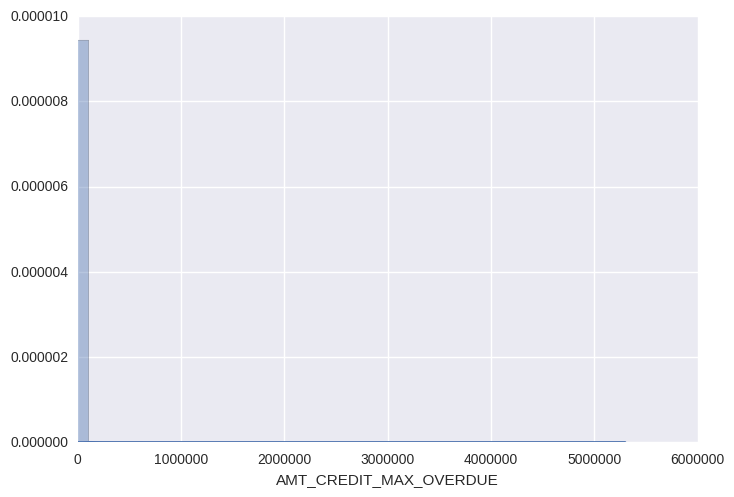

In [77]:
sns.distplot(train['AMT_CREDIT_MAX_OVERDUE'].dropna())

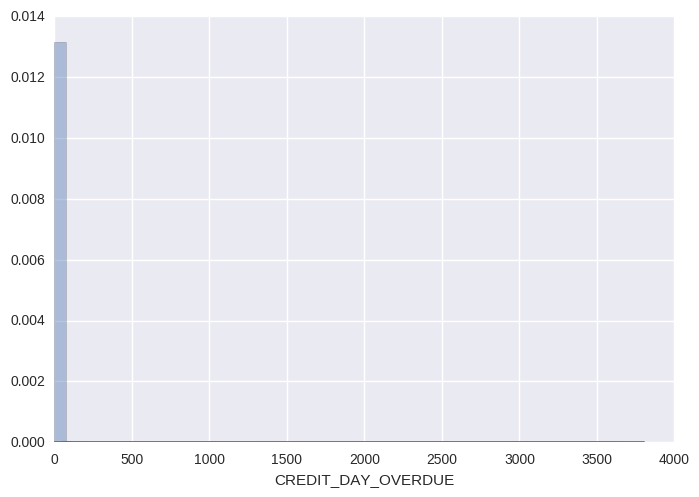

In [76]:
sns.distplot(train['CREDIT_DAY_OVERDUE'].dropna())

Взглянем поближе:

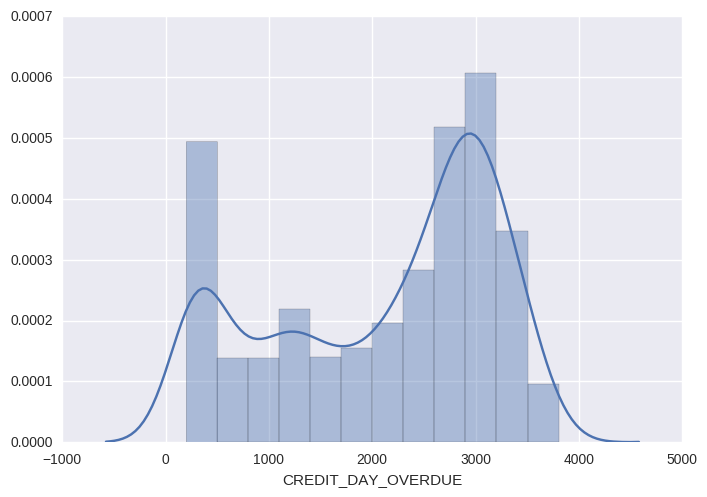

In [78]:
sns.distplot(train[train['CREDIT_DAY_OVERDUE'] > 200]['CREDIT_DAY_OVERDUE'].dropna())

По всей видимости либо нет границы, после которой 

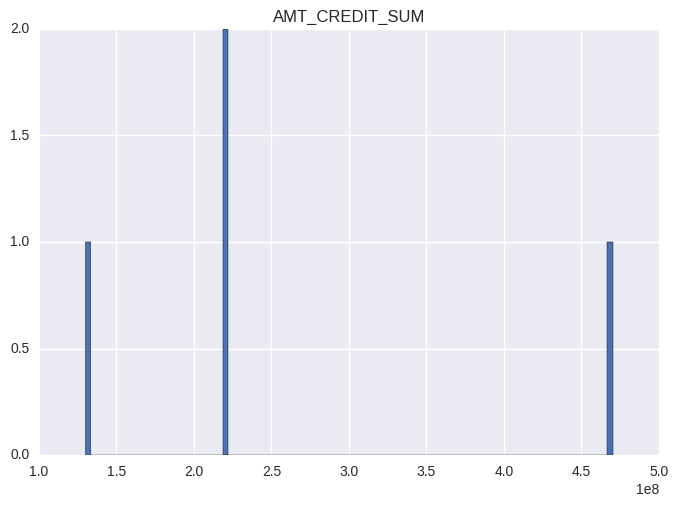

In [106]:
_ = train[train['AMT_CREDIT_SUM']>1e8].hist('AMT_CREDIT_SUM', bins=100)

Вряд ли источник данных влияет на возврат кредита. Нужно проверить.

In [96]:
train.iloc[0]['TEXT_PAYMENT_DISCIPLINE']

'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC0000000000'

Возьму отношение числа своевременных платежей к числу просрочек. 'С' стоит удалить.

In [ ]:
len(X.iloc[0]['TEXT_PAYMENT_DISCIPLINE'])

In [ ]:
X.dtypes

In [ ]:
X.CREDIT_FACILITY.unique()

In [ ]:
ID
CNT_CREDIT_PROLONG

In [ ]:
X['NUM_SOURCE'].value_counts()

In [ ]:
X.ID.value_counts()

In [ ]:
X[X.ID == 29802]

Может ли быть несколько кредитов одного типа? Наверняка

In [ ]:
for i,j in zip(X.iloc[2], X.iloc[4]):
    if i != j:
        print '{} - {}'.format(i,j)

In [ ]:
X.TEXT_PAYMENT_DISCIPLINE.astype('str').apply(lambda x: len(x))

Важна ли сама дата? Или важны лишь относительные показатели? Если второе, то ,возможно, что кроме разницы в днях есть другая важная дискретизация

In [ ]:
fill(AMT_CREDIT_SUM)

In [114]:
train.rename(columns={u'NUM_SOURCEle':u'NUM_SOURCE'}, inplace=True)

In [116]:
%%time
encode_with_OneHotEncoder_and_delete_column(train, 'NUM_SOURCE')

TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('S21') dtype('S21') dtype('S21')

In [ ]:
encode(['NUM_SOURCE', 'CREDIT_ACTIVE', 'CREDIT_COLLATERAL', 'CREDIT_CURRENCY'])

In [ ]:
sum(['CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT'])

In [ ]:
train.drop(['CREDIT_FACILITY', 'AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM_LIMIT', 'DTIME_CREDIT_ENDDATE_FACT'])

DTIME_CREDIT_ENDDATE           91370
AMT_CREDIT_SUM_DEBT           208766
AMT_ANNUITY                   475829
TEXT_PAYMENT_DISCIPLINE         1947

In [ ]:
ID                                    int64
SK_DATE_DECISION             datetime64[ns]
DTIME_CREDIT                 datetime64[ns]
CREDIT_DAY_OVERDUE                    int64
DTIME_CREDIT_ENDDATE         datetime64[ns]
DTIME_CREDIT_ENDDATE_FACT    datetime64[ns]

AMT_CREDIT_MAX_OVERDUE              float64
AMT_CREDIT_SUM_LIMIT                float64
AMT_CREDIT_SUM_OVERDUE              float64
CREDIT_SUM_TYPE                       int64
CREDIT_TYPE                           int64
DTIME_CREDIT_UPDATE                  object
CREDIT_DELAY30                        int64
CREDIT_DELAY5                         int64
CREDIT_DELAY60                        int64
CREDIT_DELAY90                        int64
CREDIT_DELAY_MORE                     int64
AMT_REQ_SOURCE_HOUR                   int64
AMT_REQ_SOURCE_DAY                    int64
AMT_REQ_SOURCE_WEEK                   int64
AMT_REQ_SOURCE_MON                    int64
AMT_REQ_SOURCE_QRT                    int64
AMT_REQ_SOURCE_YEAR                   int64
AMT_ANNUITY                         float64
TEXT_PAYMENT_DISCIPLINE

Т.к. абсолютные значения дат будут удалены, разделение на тест и обучение можно сделать не по времени, а случайно и стратифицировано.

Для валидации данные есть, нужно выделить данные для теста.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.33, random_state=2017)

In [86]:
import xgboost as xgb

In [87]:
params = {}
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['seed'] = 2017

In [ ]:
dtrain = xgb.DMatrix(train, y)

In [ ]:
xgb.cv(params, dtrain, num_boost_round=1000, stratified=True, nfold=5, early_stopping_rounds=30)

In [ ]:
bst = xgb.train(param, dtrain, num_round)

Фичи, которые хотелось бы попробовать, но не успел:
* Перекрытия дат кредитов
* 